In [1]:
h1  {
  text-align: center;
  color: navy;
  text-decoration: underline #BE05FA;
}
h2 {
  text-align: center;
  color: blue;
  text-decoration: underline #BE05FA;
}
h3 {
  text-align: center;
  color: blue;
  text-decoration: underline #BE05FA;
}
body {
  color: black;
  counter-reset:section;
}
caption {
  text-align: center;
  color: black;
}
caption::before {
    counter-increment: section;
    content:"Table - " counter(section);
}

SyntaxError: invalid syntax (Temp/ipykernel_22980/350376206.py, line 1)

In [ ]:

#  background-color: #EEF6F9;

#  Introducción 


El riesgo de crédito se refiere a la probabilidad de pérdida debido a un incumplimiento en los pagos de cualquier tipo de deuda, se cuenta con una base de datos <a href="https://drive.google.com/file/d/1xaF743cmUgI5kc76I86AeZDE84SMkMnt/view"> loan_data_2007_2014.csv </a> con información de usuarios desde 2007 a 2014 disponible en <a href ="https://www.kaggle.com/datasets/devanshi23/loan-data-2007-2014"> kaggle </a> su fuente es de <a href="https://www.lendingclub.com/" > lendingclub </a> que es un tipo de prestamista P2P (prestamos digitales) de EE. UU. contiene información reciente de interés como el estado del prestamo y varios factores que pueden influir en si la persona paga o no el prestamo.


# Objetivo


Crear un modelo de probabilidad para el incumplimiento de los pagos con la base de datos, para predecir la probabilidad de que un individuo incumpla sus obligaciones financieras en los siguientes 12 meses desde que se genero el crédito.

In [ ]:
%%R
knitr::opts_chunk$set(echo = TRUE)
library(reticulate)
library(kableExtra)

Este informe se usara con un lenguaje de programación Python usando las siguientes librerias:

-   pandas: Lectura y manejo de data frame.
-   numpy: Arreglos matriciales.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
mes_name=['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul', 'Jun', 'May', 'Apr', 'Mar', 'Feb', 'Jan']
mes_num=list(pd.Series(list((13-np.arange(1,13)))).astype("str"))
def format_replace(string_):
    for i in range(0,12):
        string_=str(string_).replace(mes_name[i],mes_num[i] )
    return string_
def dummy_creation(df_, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df_[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df_ = pd.concat([df_, df_dummies], axis = 1)
    df_=df_.drop(labels=columns_list,axis=1)
    return df_


# Depuración

In [4]:
df=pd.read_csv("loan_data_2007_2014.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df[ 'issue_d']=df[ 'issue_d'].apply(format_replace)
df['last_pymnt_d']=df['last_pymnt_d'].apply(format_replace)
df[ 'earliest_cr_line']=df[ 'earliest_cr_line'].apply(format_replace)
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'], format = "%m-%y")

La base de datos <a href="https://drive.google.com/file/d/1xaF743cmUgI5kc76I86AeZDE84SMkMnt/view"> loan_data_2007_2014.csv </a> cuenta con 74 columnas y 466285 registros.

-   Las columnas id, member_id, url, title hacen referencia a información de identificación del usuario, que no es de interés para el estudio.


## Variables primordiales

Para la creación del modelo se tienen:

- __issue_d__: El mes en que se financió el préstamo (mes-año).

- __last_pymnt_d__: El último mes de pago fue recibido.

- __loan_satus__: Esta sera la variable objetivo, cuenta con 9 categorías que clasifican el ultimo estado registrado.

## Creación de variables

Como el objetivo es crear un modelo para predecir si al cabo de 12 meses que se origina el credíto (issue_d) el usuario incumple sus obligaciones financieras, luego de analizar las variables fecha registradas se crea __month_last__: meses que han pasado desde el ultimo pago, que es la diferencia  (last_pymnt_d-issue_d ) esto nos dará informción del tiempo que pago el usuario y con la variable loan_status se podrá saber si el usuario incumple entre el tiempo de interés (antes de 12 meses).

Se crea las variables.

- __good_status__: Que tomara valores 0 (con morosidad) y 1 (Sin morosidad)

In [6]:
table_frec=pd.DataFrame(df["loan_status"].value_counts())
status_mora=['Charged Off', 'Default', 'Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']
table_frec["good_status"]=1
filtro=pd.Series(table_frec.index).isin( status_mora)
table_frec.loc[list(filtro), "good_status"]=0
table_frec=table_frec.reset_index()
table_frec.columns=["loan_status", "Frec", "good_status" ]
df_temp=table_frec[["loan_status", "good_status","Frec" ]]
df["good_status"]=1
df.loc[df["loan_status"].isin(status_mora),"good_status"]=0

`r kbl(py$df_temp, escape = F, align = "c", caption="Categorías good_status ") %>%  kable_classic_2("striped", full_width = F)`

- __month_last__: last_pymnt_d-issue_d en meses.

In [7]:
df[ 'issue_d']=pd.to_datetime(df['issue_d'], format = "%m-%y")
df['last_pymnt_d']=pd.to_datetime(df['last_pymnt_d'], format = "%m-%y")
df["month_last"]= ((df.last_pymnt_d - df.issue_d)/np.timedelta64(1, 'M'))


- __target_time__: 1 si month_last $\leq$ 12, 0 si >12.

In [8]:
df['target_time']=0
df.loc[df["month_last"]<=12,'target_time']=1

### Estructura del modelo

El modelo general tendra la estructura:

$$
P(\text{good_status=1} )= f(\text{month_last}, {X },\theta )
$$
Donde __month_last__ define el tiempo en que queremos predecir, $X$ es un vector de variables que puedan afectar la probabilidad y $\theta$ son los parámetros que puede contener el modelo.

### Valores NA

Asumiendo que se tolera al menos un 20 % de valores NA en los datos de las y omitiendo las columnas de identificación se cuenta con:


In [9]:
drop_columns=["id", "member_id", "url", "title"]
df=df.drop(labels=drop_columns,axis=1 )
total_na=df.isna().sum()
filtro=total_na< df.shape[0]*0.2
total_na=total_na[filtro]
result=pd.DataFrame({"Variables":["Menos del 20% NA"," Mas del 20% NA"],
"Total variables":[total_na.shape[0], 70-total_na.shape[0] ]} )

`r kbl(py$result, escape = F, align = "c", caption="Resumen de NA") %>%  kable_classic_2("striped", full_width = F)`

Se omiten 22 variables por su alto porcentaje de valores faltantes, aunque 20% de valores faltantes es una cantidad alta, existen variables importantes que contienen alta cantidad de valores faltantes que se muestran a continuación.

## Variables modelo


In [10]:
vars_=total_na.sort_values(ascending=False).head()
result=pd.DataFrame({"Variables":vars_.index,"Descripción":[" Total crédito rotativo alto entre límite de crédito. ","Saldo corriente en todas las cuentas ", " Montos totales de cobro adeudados. ", "Tipo de trabajo.","Años en el trabajo "   ], "Total NA":vars_ })
result=result.reset_index()

`r kbl(py$result, escape = F, align = "c", caption="Variables candidatas") %>%  kable_classic_2("striped", full_width = F)`

De estas variables puede ser dificil que el usuario obtenga __total_rev_hi_lim__, __emp_title__ tiene muchas categorías.

Es importante identificar que variables puede dar un usuario al momento del registro, pues existen variables donde se obtienen la información al pasar el tiempo o un usuario no puede identificar.


In [11]:
variables_eliminar="""funded_amnt_inv
grade
sub_grade
emp_title
verification_status
zip_code
addr_state
dti
delinq_2yrs
inq_last_6mths
revol_bal
revol_util
total_acc
out_prncp
out_prncp_inv
out_prncp_inv
total_pymnt
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_credit_pull_d
collections_12_mths_ex_med
policy_code
tot_coll_amt
total_rev_hi_lim"""
variables_eliminar=np.array(variables_eliminar.replace(" ", "").split("\n"))
variables_eliminar.shape=(7,4)
variables_eliminar=pd.DataFrame(variables_eliminar)
variables_eliminar.columns=[" "]*4

`r kbl(py$variables_eliminar, escape = F, align = "c", caption="Variables que no se incluyen") %>%  kable_classic_2("striped", full_width = F)`

Las variables en la tabla no se tienen en cuenta porque son medidas que son proporcionadas por LC, información al pasar el tiempo después del prestamo o son extraidas de un externo, por ende, las variables a considerar como influyentes en el incumplimiento de las finanzas son:



In [12]:
variables="""__loan_amnt__:El monto indicado del préstamo solicitado por el prestatario. Si en algún momento, el departamento de crédito reduce el monto del préstamo, entonces se reflejará en este valor.

__funded_amnt__: El monto total comprometido con ese préstamo en ese momento.

__term__: El número de pagos del préstamo. Los valores son en meses y pueden ser 36 o 60.

__int_rate__: tasa de interés del préstamo.

__installment__:cuota El pago mensual adeudado por el prestatario si el préstamo se origina.

__emp_length__: años trabajo

__home_ownership__: El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro. Nuestros valores son: ALQUILER, PROPIEDAD, HIPOTECA, OTRO.

__annual_inc__: Los ingresos anuales autoinformados proporcionados por el prestatario durante el registro.

__pymnt_plan__: indica si se a establecido un plan de pago.

__earliest_cr_line__: El mes en que se abrió la primera línea de crédito reportada del prestatario.

__open_acc__: El número de líneas de crédito abiertas en el archivo de crédito del prestatario.

__pub_rec__: numero de derogatory public records.

__initial_list_status__: El estado inicial de listado del préstamo. Los valores posibles son – W, F

__acc_now_delinq__:El número de cuentas en las que el prestatario está ahora en mora.

__purpose__: Razón por la que se hace el prestamo.

__tot_cur_bal__:Saldo corriente total de todas las cuentas
""".split("\n")
#.replace("__","")
variables=pd.Series(variables)
variables_= variables[~(variables=="")].apply(lambda x: x.split(":")[0])
descripcion_=variables[~(variables=="")].apply(lambda x: x.split(":")[1])
result=pd.DataFrame({"Variables": variables_, "Descripción":descripcion_ })

`r kbl(py$result, escape = F, align = "l", caption="Covariables candidatas",row.names=F) %>%  kable_classic_2("striped", full_width = F)`

En esta tabla se tienen las posibles variables para el modelo, con __good_status__ y __target_time__.


In [13]:
variables_=pd.Series(variables_).apply(lambda x: x.replace("__","" ))
df["month_earliest_cr_line"]=((df.earliest_cr_line - df.issue_d)/np.timedelta64(1, 'M'))
df=df[ [*variables_, "good_status","target_time","month_earliest_cr_line" ]] 
df=df[~df.isna().any(axis=1)]
result=pd.DataFrame({"":["Filas", "Columnas"] ,"Cantidad":df.shape})
#print_table(result, "Dimensiones")

`r kbl(py$result, escape = F, align = "l", caption="Dimensión de datos") %>%  kable_classic_2("striped", full_width = F)`

Como resultado para el modelo se usara un data frame con estas dimesiones.

# Analisis Descriptivo

¿Cuál es la distribución de __good_estatus__?


In [14]:
tabla_1=df.good_status.value_counts(normalize=True)*100
tabla_2=df.good_status.value_counts()
tabla_3=df.target_time.value_counts(normalize=True)*100
tabla_4=df.target_time.value_counts()
table_final=pd.DataFrame({"good status":[1,0],"Frecuencia":tabla_2, 
                          "Frec %":tabla_1, "target time":[0,1],
                         "Frecuencia ":tabla_4, "Frec % ":tabla_3 } )

`r kbl(py$table_final, escape = F, align = "l", caption="Distribución global",row.names=F,digits =2) %>%  kable_classic_2("striped", full_width = F)`



La variable __acc_now_delinq__ se puede transformar en 1 si tiene al menos una cuenta en mora, 0 sino tiene cunetas en mora. También la variable __pub_rec__ se transforma 1 si tiene al menos un derogatory public records, 0 sino. Se tomo la decisión ya que son variables conteos donde no parece ser necesario. Como esta es la fecha en que se hizo su primer prestamo __earliest_cr_line__, se debe calcular los meses que han pasado desde que solicito el prestamo __month_earliest_cr_line__


In [15]:
df=df.drop(labels="earliest_cr_line",axis=1)
df["acc_now_delinq"]=np.where(df["acc_now_delinq"]>0, 1,0)
df["pub_rec"]=np.where(df["pub_rec"]>0,1,0)

In [16]:
df_temp=df.copy()
df_temp["acc_now_delinq"]=df_temp["acc_now_delinq"].astype("str")
df_temp["target_time"]=df_temp["target_time"].astype("str")
df_temp["pub_rec"]=df_temp["pub_rec"].astype("str")
X=df_temp.drop(labels="good_status",axis=1)
Y=df_temp["good_status"]

X_train_cat = X.select_dtypes(include = 'object').copy()
X_train_num = X.select_dtypes(include = 'number').copy()
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(Y, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)


`r kbl(py$chi2_result, escape = F, align = "c", caption="Prueba ",row.names=F,digits =2) %>%  kable_classic_2("striped", full_width = F)`

Se realiza pruebas $\chi^2$ para las variables categoricas en contraste con la variable __good_status__ y se observa 8 variables con un p-valor pequeño, esto significa que estas variables pueden influir en el incumplimiento de las finanzas. Se excluye __pymnt_plan__ debido a un p-valor > 0.05.


<AxesSubplot:>

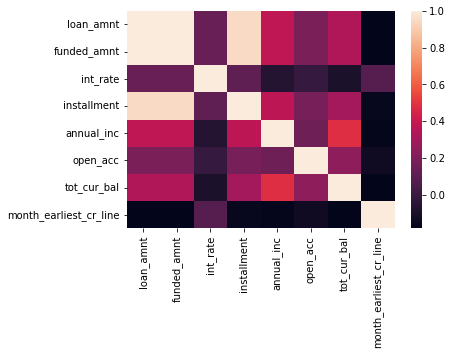

In [17]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat)

En la figura 1 se observa que hay 3 variables con una alta correlación entre si ($\approx$ 1) que son: __loan_amnt__, __funded_amnt__, __installment__ y según la table - 5 se opta por __loan_amnt__ por ser el prestamo definitivo que dio LC.

<AxesSubplot:xlabel='good_status', ylabel='month_earliest_cr_line'>

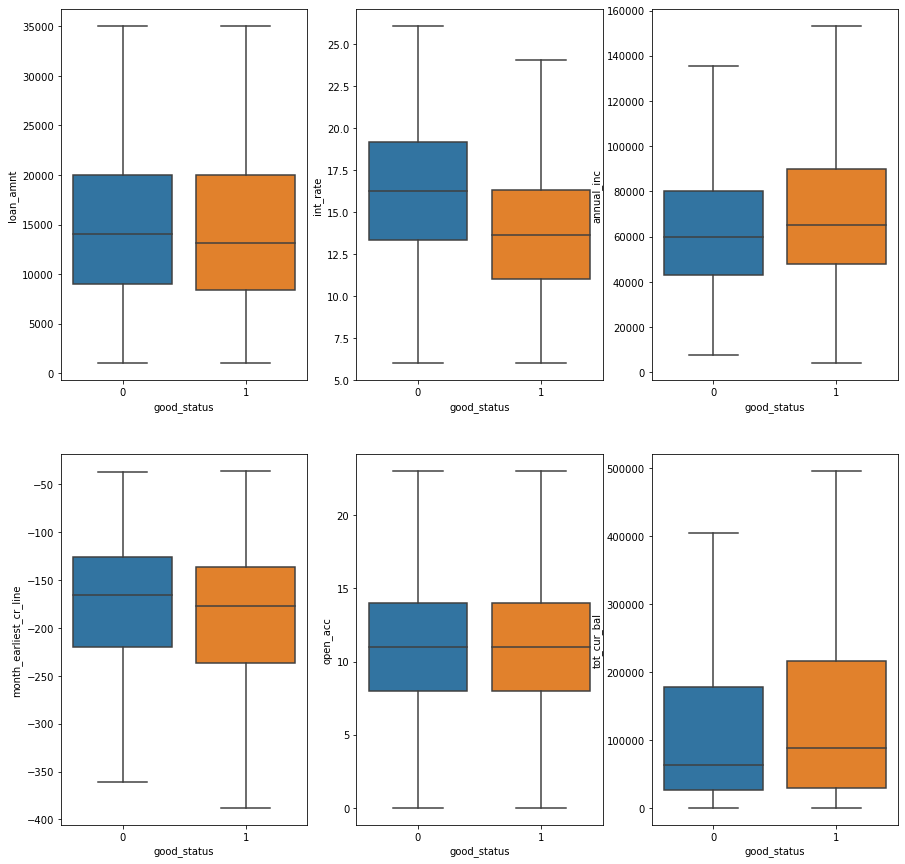

In [18]:
vars_=['loan_amnt',  'int_rate', 'annual_inc',
       'open_acc', 'tot_cur_bal',"month_earliest_cr_line"]
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15, 15))
sns.boxplot(data=df, x="good_status", y=vars_[0], ax=axs[0, 0],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[1], ax=axs[0, 1],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[2], ax=axs[0, 2],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[3], ax=axs[1, 1],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[4], ax=axs[1, 2],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[5], ax=axs[1, 0],showfliers = False)

En la figura se observa que las variables con una tendencia de influir en __good_status__ son __int_rate__, __annual_inc__ pues aunque no se observa gran diferencia, parece existir una influencia.

Las variables a usar para crear el modelo son: 

In [19]:
variables_final=list(chi2_result["Feature"].iloc[0:7])
variables_final=[*variables_final,*["int_rate", "annual_inc","good_status" ]]

In [20]:
variables_final

['term',
 'emp_length',
 'home_ownership',
 'initial_list_status',
 'purpose',
 'target_time',
 'pub_rec',
 'int_rate',
 'annual_inc',
 'good_status']

# Modelos

Se plantean diferentes modelos aplicando validación cruzada.

## Partición de datos

In [89]:
df_modelo=df[variables_final].copy()
df_modelo[df_modelo["home_ownership"] == "ANY"] = 'NONE'
df_modelo = df_modelo[df_modelo["term"] != "NONE"]
X = df_modelo.drop('good_status', axis = 1)
y = df_modelo['good_status']
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()
X_train=dummy_creation(X_train, ["term","emp_length","home_ownership","initial_list_status", "purpose" ])
X_test=dummy_creation(X_test, ["term","emp_length","home_ownership","initial_list_status", "purpose" ])

In [90]:
X_train

,target_time,pub_rec,int_rate,annual_inc,term: 36 months,term: 60 months,emp_length:1 year,emp_length:10+ years,emp_length:2 years,emp_length:3 years,...,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
282891,0,0,8.39,60000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275347,0,0,12.99,100000.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181282,0,0,7.62,120000.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
344906,0,0,16.29,54000.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
72876,0,0,17.76,60000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460396,0,0,12.85,115000.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
72197,0,0,10.99,130000.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99033,1,0,14.33,76000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326213,0,0,12.99,27000.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelo K-nn

In [91]:
score_train = []
score_test=[]
from tqdm import tqdm
for i in tqdm(range(1,20)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    score_train.append(accuracy_score(y_train[:1000], neigh.predict(X_train[:1000])))
    score_test.append(accuracy_score(y_test[:1000], neigh.predict(X_test[:1000])))
    # print(i)

100%|██████████| 19/19 [04:10<00:00, 13.17s/it]


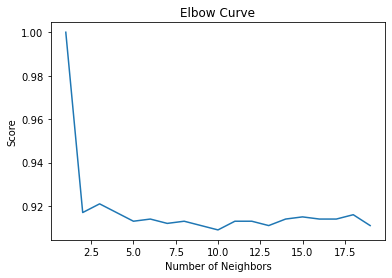

In [92]:
plt.plot(range(1,20), score_train)
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

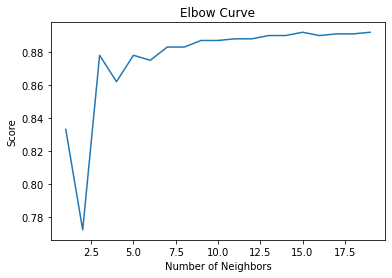

In [93]:
plt.plot(range(1,20), score_test)
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Modelo logístico 

In [ ]:
score_train

In [23]:
neigh = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

In [78]:
for i in ["term","emp_length","home_ownership","initial_list_status", "purpose" ]:
    print(X[i].value_counts())

 36 months    268358
 60 months    108703
Name: term, dtype: int64
10+ years    133152
2 years       34033
3 years       30177
< 1 year      28848
5 years       24850
1 year        24091
7 years       22787
4 years       22172
6 years       21771
8 years       19627
9 years       15553
Name: emp_length, dtype: int64
MORTGAGE    195615
RENT        148388
OWN          32975
OTHER           42
NONE            41
Name: home_ownership, dtype: int64
f    221372
w    155689
Name: initial_list_status, dtype: int64
debt_consolidation    228701
credit_card            88628
home_improvement       20310
other                  16395
major_purchase          6366
small_business          3987
medical                 3295
car                     3048
moving                  2001
vacation                1774
house                   1501
wedding                  858
renewable_energy         197
Name: purpose, dtype: int64


In [71]:
X_train.columns

Index(['target_time', 'pub_rec', 'int_rate', 'annual_inc', 'term: 36 months',
       'term: 60 months', 'emp_length:1 year', 'emp_length:10+ years',
       'emp_length:2 years', 'emp_length:3 years', 'emp_length:4 years',
       'emp_length:5 years', 'emp_length:6 years', 'emp_length:7 years',
       'emp_length:8 years', 'emp_length:9 years', 'emp_length:< 1 year',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
       'initial_list_status:f', 'initial_list_status:w', 'purpose:car',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding'],
      dtype='object')

In [72]:
X_test.columns

Index(['target_time', 'pub_rec', 'int_rate', 'annual_inc', 'term: 36 months',
       'term: 60 months', 'emp_length:1 year', 'emp_length:10+ years',
       'emp_length:2 years', 'emp_length:3 years', 'emp_length:4 years',
       'emp_length:5 years', 'emp_length:6 years', 'emp_length:7 years',
       'emp_length:8 years', 'emp_length:9 years', 'emp_length:< 1 year',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
       'initial_list_status:f', 'initial_list_status:w', 'purpose:car',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding'],
      dtype='object')

In [85]:
y.unique()

array([1, 0], dtype=object)

Modelo Naive Bayes

In [95]:
from sklearn.naive_bayes import GaussianNB

In [98]:
clf = GaussianNB()
clf.fit(X_train, y_train)
print(accuracy_score(y_train, clf.predict(X_train)))
print(accuracy_score(y_test, clf.predict(X_test)))

0.8999927067310243
0.899990717780754


de notebook a R markdwon 

In [ ]:
# import jupytext
# !jupytext --to rmarkdown informe_prueba.ipynb